# Predicción de Riesgo de Enfermedad Cardíaca con Regresión Logística

En este notebook se implementa un modelo de regresión logística desde cero para predecir la presencia de enfermedad cardíaca a partir de variables clínicas. El flujo de trabajo incluye análisis exploratorio de datos (EDA), preprocesamiento, entrenamiento del modelo, regularización y evaluación.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


## Step 1: Carga y Preparación del Dataset

In [3]:
df = pd.read_csv("Heart_Disease_Prediction.csv")
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


El dataset fue cargado correctamente desde el archivo CSV y contiene información clínica de pacientes, incluyendo edad, presión arterial, colesterol y diagnóstico de enfermedad cardíaca.

### Exploración inicial del dataset


In [4]:
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    str    
dtypes: float64(1), int64(12), str(1)
memo

El dataset contiene 270 observaciones y 14 variables. La mayoría de las variables son numéricas y no se observan valores faltantes.

### Binarización de la variable objetivo
La variable objetivo *Heart Disease* se transformó a un formato binario, donde:
- 1 indica presencia de enfermedad cardíaca
- 0 indica ausencia de enfermedad cardíaca

In [5]:
df["Heart Disease"] = df["Heart Disease"].map({
    "Presence": 1,
    "Absence": 0
})

In [6]:
df["Heart Disease"].value_counts()

Heart Disease
0    150
1    120
Name: count, dtype: int64

### Distribución de la variable objetivo
Se analiza la proporción de pacientes con y sin enfermedad cardíaca para identificar posibles desbalances de clase.

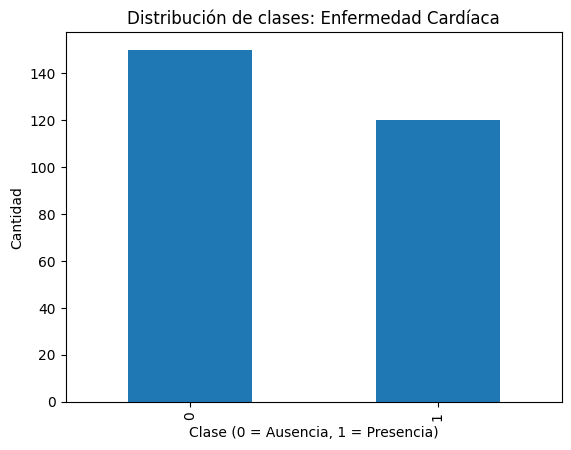

In [10]:
y_counts = df["Heart Disease"].value_counts()

y_counts.plot(kind="bar")
plt.title("Distribución de clases: Enfermedad Cardíaca")
plt.xlabel("Clase (0 = Ausencia, 1 = Presencia)")
plt.ylabel("Cantidad")
plt.show()

La distribución de clases muestra una ligera diferencia entre pacientes con y sin enfermedad cardíaca, sin presentar un desbalance severo que requiera técnicas adicionales de balanceo.

### Selección de variables
Se seleccionaron las siguientes variables por su relevancia clínica y su uso frecuente en estudios de riesgo cardiovascular:
- Age
- BP
- Cholesterol
- Max HR
- ST depression
- Number of vessels fluro

In [7]:
features = [
    "Age",
    "BP",
    "Cholesterol",
    "Max HR",
    "ST depression",
    "Number of vessels fluro"
]

X = df[features].values
y = df["Heart Disease"].values

### Normalización de variables
Las variables numéricas fueron normalizadas para tener media cero y desviación estándar uno, con el fin de mejorar la convergencia del algoritmo de descenso por gradiente.

In [8]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

X = (X - X_mean) / X_std

### División del conjunto de datos
El conjunto de datos fue dividido en 70% para entrenamiento y 30% para prueba, manteniendo la proporción entre clases.

In [9]:
np.random.seed(42)

indices = np.arange(len(X))
np.random.shuffle(indices)

split = int(0.7 * len(X))

train_idx = indices[:split]
test_idx = indices[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

## Step 2: Implementación de la Regresión Logística
### Función sigmoide
La función sigmoide transforma cualquier valor real en un valor entre 0 y 1, interpretado como una probabilidad.

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [12]:
sigmoid(np.array([-10, 0, 10]))

array([4.53978687e-05, 5.00000000e-01, 9.99954602e-01])

### Función de costo
Se utiliza la entropía cruzada binaria para medir el error entre las probabilidades predichas y las etiquetas reales.

In [13]:
def compute_cost(X, y, w, b):
    m = len(y)
    z = X @ w + b
    y_hat = sigmoid(z)
    
    cost = -(1/m) * np.sum(
        y * np.log(y_hat + 1e-8) + (1 - y) * np.log(1 - y_hat + 1e-8)
    )
    return cost

### Cálculo de gradientes
Se calculan las derivadas parciales del costo respecto a los pesos y el sesgo.

In [14]:
def compute_gradients(X, y, w, b):
    m = len(y)
    z = X @ w + b
    y_hat = sigmoid(z)
    
    dw = (1/m) * (X.T @ (y_hat - y))
    db = (1/m) * np.sum(y_hat - y)
    
    return dw, db

### Descenso por gradiente
Se optimizan los parámetros del modelo minimizando la función de costo.

In [15]:
def gradient_descent(X, y, w, b, alpha, iterations):
    costs = []

    for i in range(iterations):
        dw, db = compute_gradients(X, y, w, b)
        
        w = w - alpha * dw
        b = b - alpha * db
        
        cost = compute_cost(X, y, w, b)
        costs.append(cost)
        
    return w, b, costs

### Entrenamiento del modelo
El modelo se entrena usando descenso por gradiente.

In [16]:
n_features = X_train.shape[1]
w = np.zeros(n_features)
b = 0

alpha = 0.01
iterations = 1500

w, b, costs = gradient_descent(X_train, y_train, w, b, alpha, iterations)

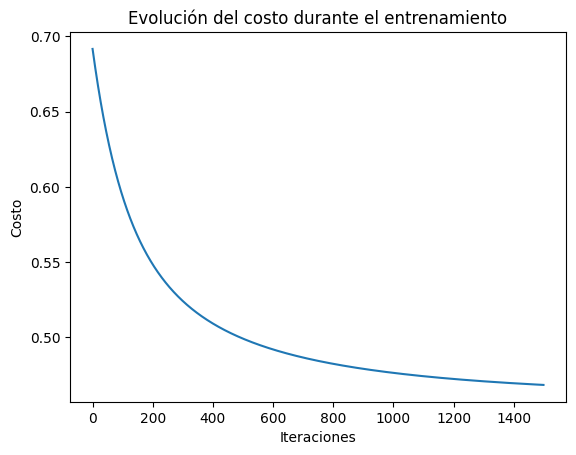

In [17]:
plt.plot(costs)
plt.xlabel("Iteraciones")
plt.ylabel("Costo")
plt.title("Evolución del costo durante el entrenamiento")
plt.show()